# Wstęp

Steganografia jest nauką o ukrywaniu obecności komunikatów w jawnym medium. W jej najprostszym wydaniu próbujemy przekazać tajne informacje w sposób, o którym wie nadawca i prawdziwy odbiorca komunikatu (który musi wiedzieć jak wiadomości szukać). Ewentualni obserwatorzy komunikacji nie będą wiedzieli, że ukryta komunikacja w ogóle zaszła.

Jednym ze starszych przykładów steganografi jest np. użycie atramentu sympatycznego, albo oznaczenie w jakiś sposób konkretnych liter w tekście (np. kropeczkami, które są niezauważalne na pierwszy rzut oka). W kontekście stron internetowych popularne jest zamieszczanie tekstu korzystając z tego samego koloru czcionki i tła. Na podobnej zasadzie można przeprowadzić ciekawy atak: <span style="background-color: #EEEEEE">
echo "Nie wklejaj <span style="position: absolute; left: -100px; top: -100px">"; clear; echo -n "Co ja właśnie powiedzialem ";whoami|tr -d '\n';echo "?!"<br> echo "Nie wklejaj </span> tego do konsoli"

Wiadomość można również ukryć w większości plików po prostu dopisując ją na jego końcu. Dzięki temu, że większość formatów plików zawiera sekwencję kończącą (ciąg konkretnych bajtów) plik ciągle będzie możliwy do odczytania (`echo -n 'Hello there' >> file.jpg`, `hexdump -C file.jpg`). Na tych laboratoriach skupimy się jednak na metodach ukrywania informacji w samym obrazie.

## Zmiana wartości pikseli

Najprostszym sposobem ukrycia informacji w obrazie jest zmiana wartości poszczególnych pikseli - konkretnie ich najmniej znaczących bitów (LSB - Least Significant Bit), ponieważ te mają niewielki wpływ na wygląd obrazu. Istnieje kilka wariantów LSB, które określają w jaki sposób dany piksel jest zmieniany. Klasyczne podejście zakłada zmianę danego bitu na właściwy, jeżeli ten róźni się od bitu wiadomości. Alternatywnie, w przypadku różnic pomiędzy wiadomością, a danym bitem obrazka, można do niego losowo dodawać +1/-1. Efekt będzie ten sam, a utrudniamy wykrycie modyfikacji. W przypadku obrazów kolorowych najczęściej modyfikuje się bity każdego kanału danego piksela w zadanej kolejności. Aby utrudnić wykrycie wiadomości można ustalić cykliczną sekwencję kanałów, które będą modyfikowane dla każdego piksela (np. dla pierwszego piksela modyfikujemy kanał B, dla drugiego R, itd.). Sekwencja nie musi mieć długości 3.

Wadą tego typu technik jest to, że działaja one prawidłowo tylko dla obrazów z kompresją bezstratną - większość algorytmów kompresji stratnej zmieni najmłodsze bity obrazka. W związku z tym, poniższe przykłady będą bazowały na obrazach w formacie PNG.


Czy potrafisz znaleźć ukrytą wiadomość znajdującą się w tym paragrafie?

In [1]:
"""Function definitions that are used in LSB steganography."""
from matplotlib import pyplot as plt
import numpy as np
import binascii
import cv2 as cv
import math
plt.rcParams["figure.figsize"] = (18,10)


def encode_as_binary_array(msg):
    """Encode a message as a binary string."""
    msg = msg.encode("utf-8")
    msg = msg.hex()
    msg = [msg[i:i + 2] for i in range(0, len(msg), 2)]
    msg = [ "{:08b}".format(int(el, base=16)) for el in msg]
    return "".join(msg)


def decode_from_binary_array(array):
    """Decode a binary string to utf8."""
    array = [array[i:i+8] for i in range(0, len(array), 8)]
    if len(array[-1]) != 8:
        array[-1] = array[-1] + "0" * (8 - len(array[-1]))
    array = [ "{:02x}".format(int(el, 2)) for el in array]
    array = "".join(array)
    result = binascii.unhexlify(array)
    return result.decode("utf-8", errors="replace")


def load_image(path, pad=False):
    """Load an image.
    
    If pad is set then pad an image to multiple of 8 pixels.
    """
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    if pad:
        y_pad = 8 - (image.shape[0] % 8)
        x_pad = 8 - (image.shape[1] % 8)
        image = np.pad(
            image, ((0, y_pad), (0, x_pad) ,(0, 0)), mode='constant')
    return image


def save_image(path, image):
    """Save an image."""
    plt.imsave(path, image) 


def clamp(n, minn, maxn):
    """Clamp the n value to be in range (minn, maxn)."""
    return max(min(maxn, n), minn)


def hide_message(image, message, nbits=1):
    """Hide a message in an image (LSB).
    
    nbits: number of least significant bits
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    if len(message) > len(image) * nbits:
        raise ValueError("Message is to long :(")
    
    chunks = [message[i:i + nbits] for i in range(0, len(message), nbits)]
    for i, chunk in enumerate(chunks):
        byte = "{:08b}".format(image[i])
        new_byte = byte[:-nbits] + chunk
        image[i] = int(new_byte, 2)
        
    return image.reshape(shape)


def reveal_message(image, nbits=1, length=0):
    """Reveal the hidden message.
    
    nbits: number of least significant bits
    length: length of the message in bits.
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels or length_in_pixels <= 0:
        length_in_pixels = len(image)
    
    message = ""
    i = 0
    while i < length_in_pixels:
        byte = "{:08b}".format(image[i])
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message

### Ukryjmy tekst w obrazku

Powyżej zdefiniowano kilka funkcji, które pozwolą ukryć wiadomość w danym obrazku. Dwie pierwsze (`encode_as_binary_array` i `decode_from_binary_array`) służą do zamiany tekstu na ciąg bitów i odwrotnie. Do ich implementacji wykorzystano ciągi znakowe (`str`), co nie jest najwydajniejszą opcją, ale ułatwia interpretacje kodu. Niżej zaprezentowano działanie tych funkcji.

In [2]:
message = "Moja tajna wiadomość"
binary = encode_as_binary_array(message)
print("Binary:", binary)
message = decode_from_binary_array(binary)
print("Retrieved message:", message)

Binary: 01001101011011110110101001100001001000000111010001100001011010100110111001100001001000000111011101101001011000010110010001101111011011010110111111000101100110111100010010000111
Retrieved message: Moja tajna wiadomość


Funkcje `hide_message` i `reveal_message` służą kolejno do ukrycia wiadomości w podanym obrazku i odzyskania jej. Przyjmują one następujące parametry:

1. image: macierz zawierająca obraz (z ukrytą wiadomością lub bez niej)
2. message: wiadomość, którą chcemy ukryć (`str` zawierający zera i jedynki)
3. nbits: liczba najmłodszych bitów poszczególnych kanałów na których checemy ukryć wiadomość (lub ukryto wiadomość)
4. length: długość ukrytej wiadomości (w przypadku podania zera funkcja ekstrahuje bity wszystkich pikseli)

Wiadomości są ukrywane na pierwszych N bajtach obrazka. Spróbujmy ukryć wiadomość w obrazku:

Czasie największej rozkoszy w życiu mego narodu - od otwarcia sklepów do ich zamknięcia!
nF��j'�$�I$�q؜q��p 'c�;m���ؓ�'m��c��q'm���� �����Ƕ�m��m�������T�I[mIUUUZ�q�


Text(0.5, 1.0, 'JPG image')

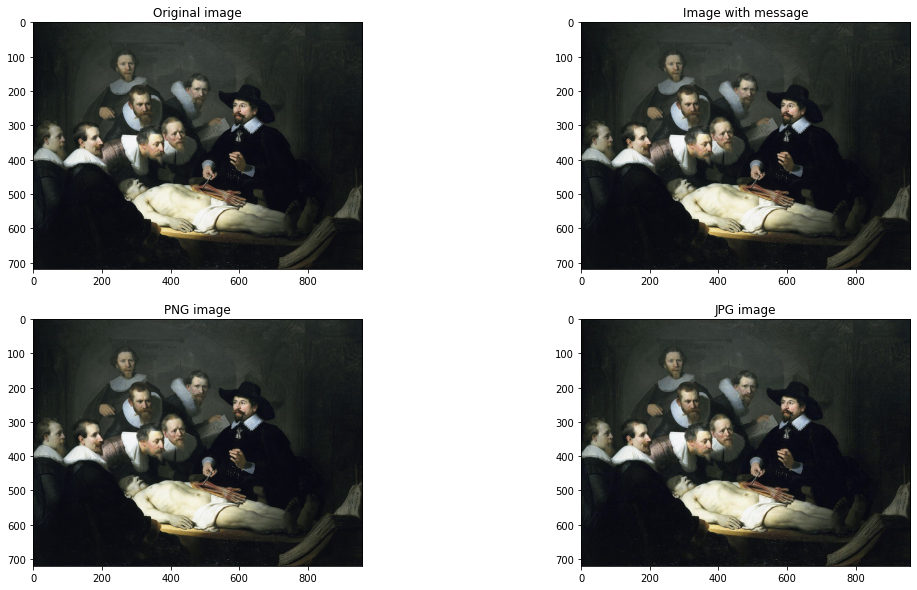

In [3]:
original_image = load_image("images/rembrandt.png")  # Wczytanie obrazka
# Mnożenie stringów działa jak zwielokratnianie
message = "Czasie największej rozkoszy w życiu mego narodu - od otwarcia sklepów do ich zamknięcia!" * 1
n = 1  # liczba najmłodszych bitów używanych do ukrycia wiadomości

message = encode_as_binary_array(message)  # Zakodowanie wiadomości jako ciąg 0 i 1
image_with_message = hide_message(original_image, message, n)  # Ukrycie wiadomości w obrazku

save_image("images/image_with_message.png", image_with_message)  # Zapisanie obrazka w formacie PNG
save_image("images/image_with_message.jpg", image_with_message)  # Zapisanie obrazka w formacie JPG

image_with_message_png = load_image("images/image_with_message.png")  # Wczytanie obrazka PNG
image_with_message_jpg = load_image("images/image_with_message.jpg")  # Wczytanie obrazka JPG

secret_message_png = decode_from_binary_array(
    reveal_message(image_with_message_png, nbits=n, length=len(message)))  # Odczytanie ukrytej wiadomości z PNG
secret_message_jpg = decode_from_binary_array(
    reveal_message(image_with_message_jpg, nbits=n, length=len(message)))  # Odczytanie ukrytej wiadomości z JPG

print(secret_message_png)
print(secret_message_jpg)

# Wyświetlenie obrazków
f, ar = plt.subplots(2,2)
ar[0,0].imshow(original_image)
ar[0,0].set_title("Original image")
ar[0,1].imshow(image_with_message)
ar[0,1].set_title("Image with message")
ar[1,0].imshow(image_with_message_png)
ar[1,0].set_title("PNG image")
ar[1,1].imshow(image_with_message_jpg)
ar[1,1].set_title("JPG image")

Widzimy, że dla pliku PNG nasza wiadomość pozostała niezmieniona, ale obrazek zapisany w formacie JPG utracił tajną wiadomość. Tak jak było to wspomniane wyżej, wynika to z faktu użycia kompresji stratnej. W zwiazku z tym, czy można zapisać w formacie JPEG tajną wiadomość? Tak i o tym opowiemy sobie później, ale najpierw...

### Ukryjmy obrazek w obrazku

Ukryć inny obrazek w obrazku można na wiele sposobów. Na przykład, możemy wygenerować obraz o ograniczonej liczbie kolorów (ograniczonej do liczby najmłodszych bitów, które będziemy zmieniać) i niejako zatopić jeden obraz w drugim (podobnie jak było to robione wyżej z wiadomością tekstową). Przy takim podejściu problemem może być rozmiar obrazka (musiałby on być nie większy niż obraz-nośnik) i przypisanie kolorów do danych wartości (żeby ograniczyć paletę kolorów i tym samym zmniejszyć rozmiar obrazka moglibysmy użyć algorytmu K-means - instrukcja 2). Problem przypisania wartości do kolorów można rozwiązać poprzez ich tablicę - jest to tzw. tryb indeksowany, w którym obraz składa się z dwóch macierzy: listy kolorów i obrazu właściwego, którego komórki zawierają nie wartości kanałów a indeksy do listy kolorów. Formatem działającym w tym trybie jest np. GIF (przy okazji, to w tablicy kolorów też można ukryć informacje wykorzystując fakt, że kolejność barw nie ma znaczenia). Oczywiście można też prościej (i prawdopodobnie o wiele sensowniej) potraktować plik jako to czym jest w rzeczywistości (ciągiem bitów) i po prostu zapisać je do obrazka, tak jak to robiliśmy wyżej z tekstem. W ten sposób możemy np. zapisać obraz JPG w obrazie PNG (obraz JPG jest znacznie mniejszy):

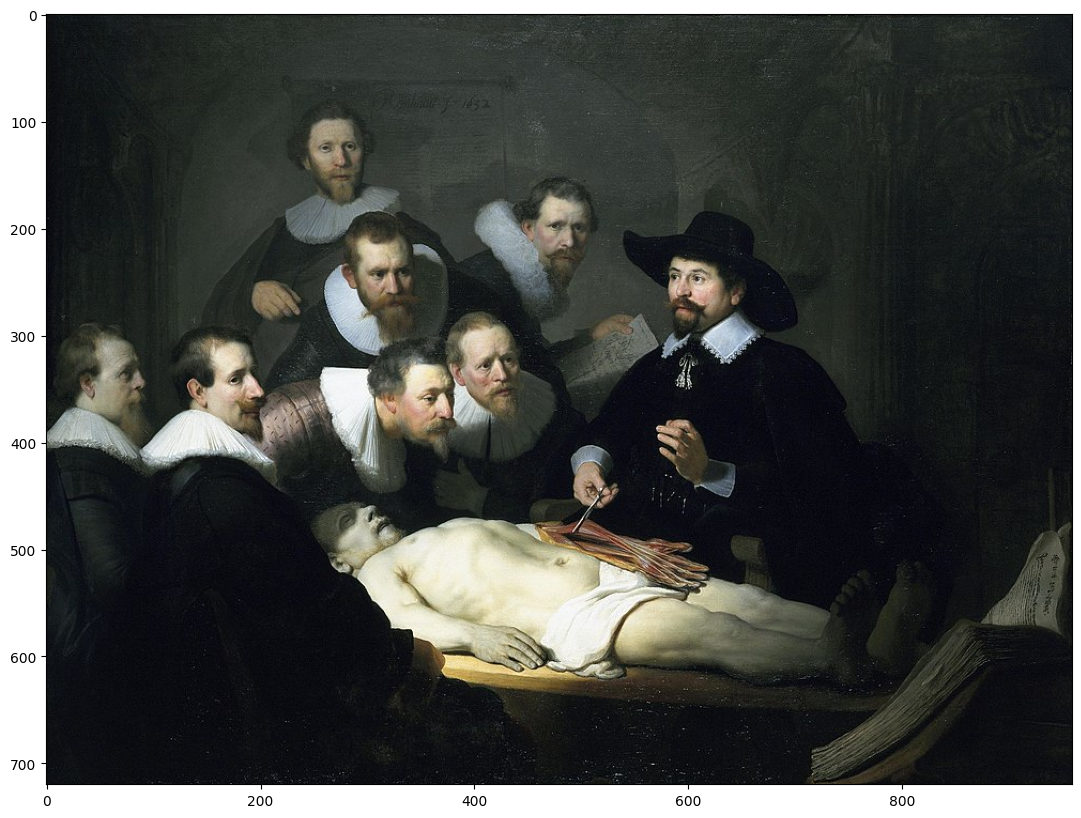

In [5]:
def hide_image(image, secret_image_path, nbits=1):
    with open(secret_image_path, "rb") as file:
        secret_img = file.read()
        
    secret_img = secret_img.hex()
    secret_img = [secret_img[i:i + 2] for i in range(0, len(secret_img), 2)]
    secret_img = ["{:08b}".format(int(el, base=16)) for el in secret_img]
    secret_img = "".join(secret_img)
    return hide_message(image, secret_img, nbits), len(secret_img)

image = load_image("images/rembrandt.png")
image_with_secret, length_of_secret = hide_image(image, "images/spanish.jpg", 1)
plt.imshow(image_with_secret)

Na obrazku nie widać śladu wiadomości (zresztą zajmuje ona tylko drobny fragment powyższego obrazu). Proszę poeksperymentować z wartością `nbits`. Stworzenie funkcji, która znajduje ukryty obrazek i zapisuje go do pliku będzie jednym z zadań.

## Zmiana wartości w przekształconej dziedzinie.

Zgodnie z obietnicą, spróbujmy ukryć wiadomość w pliku z kompresją JPEG. Najpierw przypomnijmy sobie jak wygląda algorytm kodowania JPEG:

1. Konwersja modelu barw: RGB -> YCbCr.
2. Przeskalowanie w dół (stratne) macierzy składowych Cb i Cr.
3. Podział obrazu na bloki o rozmiarze 8x8.
4. Wykonanie dyskretnej transformacji cosinusowej na każdym bloku obrazu.
5. Podzielenie każdego bloku obrazu przez macierz kwantyzacji.
6. Zaokrąglenie wartości w każdym bloku do liczb całkowitych.
7. Zwinięcie każdego bloku 8x8 do wiersza 1x64 – algorytm ZigZag.
8. Zakodowanie danych obrazu – m.in. algorytmem Huffmana.

Ostatnim krokiem, w którym rzeczywiście tracimy informacje, jest krok 6. W związku z tym, większość technik ukrywania wiadomości w plikach JPEG polega na zmianie bloków obrazu (kanału) właśnie po kwantyzacji (znajdujemy się w dziedzinie częstotliwości). Najprostszą metodą jest znowu zmiana najmłodszego bitu wartości w tych macierzach (LSB), ale tym razem nie będziemy mogli zmieniać:

1. zer - ponieważ może to znacząco zwiększyć wielkość pliku wyjściowego,
2. jedynek - ponieważ mogą się zmienić w zera.

Po zmianie bloków należałoby kontynuować algorytm (krok 7 i 8) i zapisać dane do pliku, ale że implementacja pełnego formatu danych wychodzi poza zakres tego kursu, to zamiast tego cofiemy się z powrotem do formatu RGB (wykonując odwrotne kroki w odwrotnej kolejności) i zapiszemy obraz korzystając z biblioteki. Wiadomość będziemy kodować jedynie w kanale Y.

In [5]:
"""Function definitions that are used in JPEG LSB steganography."""
from scipy.fftpack import dct
from scipy.fftpack import idct
from PIL import Image

# Quantization matrix 
QY = np.array([[16, 11, 10, 16, 24, 40, 51, 61], 
              [12, 12, 14, 19, 26, 48, 60, 55], 
              [14, 13, 16, 24, 40, 57, 69, 56], 
              [14, 17, 22, 29, 51, 87, 80, 62], 
              [18, 22, 37, 56, 68, 109, 103, 77], 
              [24, 35, 55, 64, 81, 104, 113, 92], 
              [49, 64, 78, 87, 103, 121, 120, 101], 
              [72, 92, 95, 98, 112, 100, 103, 99]], dtype=np.float64)
QY = np.ceil(QY / 2)


def dct2(array):
    """Discrete cosine transform."""
    return dct(dct(array, axis=0, norm='ortho'), axis=1, norm='ortho')


def idct2(array):
    """Inverse discrete cosine transform."""
    return idct(idct(array, axis=0, norm='ortho'), axis=1, norm='ortho')


def split_channel_to_blocks(channel):
    """Splits channel into blocks 8x8"""
    blocks = []
    for i in range(0, channel.shape[0], 8):
        for j in range(0, channel.shape[1], 8):
            blocks.append(channel[i:i + 8, j:j + 8])
    return blocks


def merge_blocks_to_channel(blocks, width):
    """Merge 8x8 blocks into """
    step = int(width / 8)
    rows = []
    for i in range(0, len(blocks), step):
        rows.append(np.concatenate(blocks[i:i + step], axis=1))
    channel = np.concatenate(rows, axis=0)
    return channel


def hide_message(blocks, message):
    """Hide a message in blocks."""
    blocks = [b.astype(np.int32) for b in blocks]
    i = 0
    for nb in range(len(blocks)):
        for x, y in [(x, y) for x in range(8) for y in range(8)]:
            value = blocks[nb][x, y]
            if i >= len(message):
                break
            if value == 0 or value == 1:
                continue
            m = message[i]
            i += 1
            v = np.binary_repr(value, width=32)
            new_value = np.int32(int(v[:-1] + m, 2))
            blocks[nb][x, y] = new_value
    
    if i < len(message):
        print("Could not encode whole message")
    return blocks


def reveal_message(blocks, length=0):
    """Reveal message from blocks.
    
    length: length of the message in bits
    """
    blocks = [b.astype(np.int32) for b in blocks]
    message = ""
    i = 0
    for block in blocks:
        for x, y in [(x, y) for x in range(8) for y in range(8)]:
            value = block[x ,y]
            if value == 0 or value == 1:
                continue
            message += np.binary_repr(value, width=32)[-1]    
            i += 1
            if i >= length:
                return message
            

def y_to_dct_blocks(Y):
    """Convert Y to quantized dct blocks."""
    Y = Y.astype(np.float32)
    blocks = split_channel_to_blocks(Y)
    blocks = [dct2(block) for block in blocks]
    blocks = [np.round(block / QY) for block in blocks]
    return blocks


def dct_blocks_to_y(blocks, image_width):
    """Convert quantized dct blocks to Y."""
    blocks = [block * QY for block in blocks]
    blocks = [idct2(block) for block in blocks]
    Y = merge_blocks_to_channel(blocks, image_width).round()
    return Y


Message from dct:  Ala ma kota
Message from JPEG file:  Ala ma kota


Text(0.5, 1.0, 'Image with message loaded from JPEG')

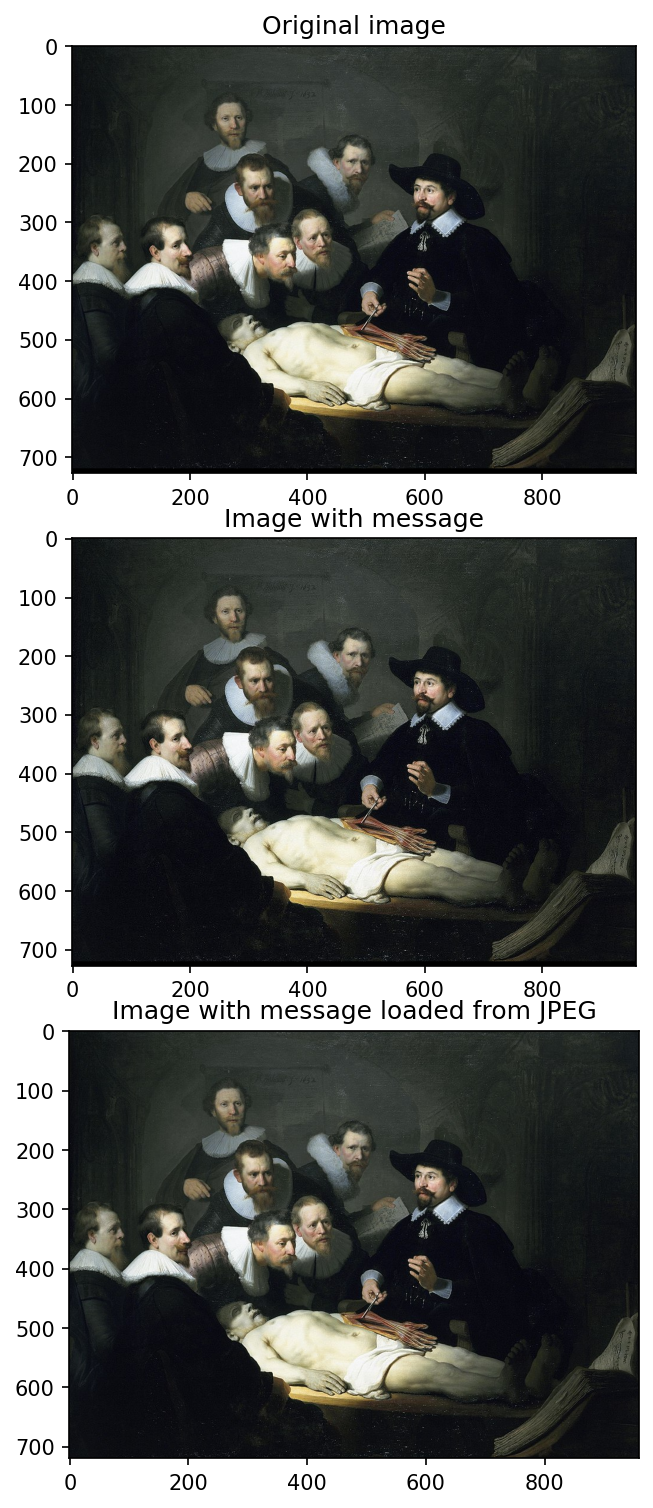

In [6]:
original_image = load_image("images/rembrandt.png", True)
message = "Ala ma kota"

# Convert to YCbCr
image = cv.cvtColor(original_image, cv.COLOR_RGB2YCrCb)

# Split channels
Y = image[:, :, 0]
Cr = image[:, :, 1]
Cb = image[:, :, 2]

# Convert Y to quantized dct blocks
blocks = y_to_dct_blocks(Y)

# Hide message
blocks = hide_message(blocks, encode_as_binary_array(message))

# Check if message is there
message_from_dct = reveal_message(blocks, len(encode_as_binary_array(message)))
print("Message from dct: ", decode_from_binary_array(message_from_dct))

# Retrive Y
Y = dct_blocks_to_y(blocks, image.shape[1])

# Merge channels
image = np.stack([Y, Cr, Cb], axis=2)

# Convert to RGB
image = np.clip(image, 0, 255)
image = image.astype(np.uint8)
image_with_message = cv.cvtColor(image, cv.COLOR_YCrCb2RGB)

# Save image as JPEG
save_image("images/image_with_message2.jpg", image_with_message)

# Load saved image
loaded_image_with_message = load_image("images/image_with_message2.jpg", True)

# Retrive message from loaded image
loaded_image_with_message = cv.cvtColor(loaded_image_with_message, cv.COLOR_RGB2YCrCb)
Y = loaded_image_with_message[:, :, 0]
Cr = loaded_image_with_message[:, :, 1]
Cb = loaded_image_with_message[:, :, 2]
blocks = y_to_dct_blocks(Y)
message_from_dct = reveal_message(blocks, len(encode_as_binary_array(message)))
print("Message from JPEG file: ", decode_from_binary_array(message_from_dct))


# Show all images
f, ar = plt.subplots(3, dpi=150)
f.tight_layout()
ar[0].imshow(original_image)
ar[0].set_title("Original image")
ar[1].imshow(image_with_message)
ar[1].set_title("Image with message")
ar[2].imshow(image_with_message_png)
ar[2].set_title("Image with message loaded from JPEG")

Widzimy, że przykładowa wiadomość została zachowana, ale jej część ulegnie zniekształceniu (mimo że macierz kwantyzacji funkcji zapisującej jest taka sama jak ta, której użyliśmy my). Kiedy po zapisaniu wiadomości w komórkach macierzy DCT dokonujemy transformacji odwrotnej, to mogą się w niej pojawić wartości ujemne, które następnie przycinamy do zadanego zakresu (od 0 do 255). W związku z powyższym, jeżeli jeszcze raz przejdziemy procedurę algorytmu JPEG, to będziemy kodowali inny obrazek niż na początku i część wartości może zmienić się na tyle, żeby pokonać próg zaokrąglania w górę/dół (0.5) - powoduje to zmianę pojedynczych bitów. Aby uchronić się przed tym zjawiskiem należałoby kontunuować algorytm JPEG (krok 7 i 8) i samemu stworzyć funkcję zapisującą do pliku (alternatywnie można skorzystać z jakiejś gotowej biblioteki i wniej nadpisać funkcje odpowiedzialną za kwantyzacje macierzy).

Na szczęście błędy powinny być drobne i przy odrobinie cierpliwości można je również (przynajmniej częściowo) zlikwidować dostosowując macierz kwantyzacji QY (np. w następujący sposób: `QY = np.ceil(QY / 2 + k)`).

Jeżeli nie udało Ci się znaleźć ukrytej wiadomości w drugim paragrafie to dobrze - żadnej tam nie było xD

# Zadania

1. (3.0) Korzystając z podanych wyżej funkcji ukryć dowolną wiadomość w dowolnym obrazku.
2. (3.5) Korzystając z kodu znajdującego się w punkcie `Ukryjmy tekst w obrazku` wygenerować i wyświetlić szerego obrazków z ukrytą wiadomością:
    1. Wiadomość dla nbits=1 ma zajmować znakomitą większość obrazka (powyżej 75%).
    2. Każdy kolejny obrazek należy generować z większą wartością nbits (do 8) - będzie 8 obrazków z wiadomością.
    3. Dla każdego obrazka należy policzyć MSE z oryginałem.
    4. Wartości MSE należy umieścić na wykresie (wykres ten należy wyświetlić w notebooku), w którym oś x stanowić będzie nbits.
    5. Źródło tekstu jest dowolne, ale proponuję użyć czegoś w stylu (https://pypi.org/project/lorem/).
    6. Do rysowania wykresu można wykorzystać funkcję `matplotlib.pyplot.plot`
3. (4.0) Przerobić funkcje `reveal_message` i `hide_message` z punktu `Zmiana wartości pikseli` w taki sposób, aby pozwalały zapisywać i odczytywać wiadomość zaczynająć od zadanej pozycji (funkcje można napisać od nowa, ale wyjście ma pozostać niezmienione). Sygnatury funkcji powinny wyglądać następująco (spos to pozycja początkowa):

    1. `def hide_message(image, message, nbits=1, spos=0)`
    2. `def reveal_message(image, nbits=1, length=0, spos=0):`

4. (4.5) Napisać program, który odzyska obrazek z obrazka zapisanego w punkcie 'Ukryjmy obrazek w obrazku'. Funkcja dekodująca (odnajdująca wiadomość) powinna przyjmować następujące parametry: 
    1. image - obrazek z ukrytym obrazkiem
    2. length - długość ukrytego obrazka
    3. nbits - liczba najmłodszych bitów użyta do zakodowania obrazka
5. (5.0) Przekazywanie długości ukrytej wiadomości do funkcji odzyskującej nie jest ładnym rozwiązaniem. W przypadku tajnego tekstu można by było zapisywać na jego końcu znak `\0`, który oznaczałby koniec ciągu znaków. W przypadku ukrytych obrazków można by było wykorzystać standardowy nagłówek i stopkę pliku (i tego dotyczy to zadanie).

    Należy zmodyfikować program napisany w poprzednim punkcie tak, aby funkcja dekodująca nie potrzebowała parametru `length`
    
    Uwagi:
    - w zadaniu wymagane jest jedynie szukanie stopki (plik może być na początku obrazka)
    - istnieje mała szansa, że stopka będzie występowała naturalnie w danych - należy wziąć pozycję pierwszego wystąpnienia (w tym i większości przypadków to zadziała, ale normalnie powinno się dokładniej przeanalizować nagłówek). 